In [1]:
import argparse
from glob import glob

import numpy as np
from PIL import Image
from keras import backend as K
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, MaxPooling2D
from keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout, ReLU
from keras.models import Model
from keras.optimizers import Adam
from numpy import random
import tensorflow as tf
from random import randint
import keras
from keras_preprocessing import image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from skimage.transform import resize
from skimage.morphology import label
from pycocotools import mask as maskUtils
from tqdm import tqdm
import os
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [0]:
batch_size = 16
input_shape = (64, 64)

def get_unet(do=0, activation=ReLU):
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics=['accuracy'])


    return model


def read_input(path):
    x = np.array(Image.open(path))/255.
    return x


def read_gt(path):
    x = np.array(Image.open(path))/255.
    return x[..., np.newaxis]


def random_crop(img, mask, crop_size=input_shape[0]):
    imgheight= img.shape[0]
    imgwidth = img.shape[1]
    i = randint(0, imgheight-crop_size)
    j = randint(0, imgwidth-crop_size)

    return img[i:(i+crop_size), j:(j+crop_size), :], mask[i:(i+crop_size), j:(j+crop_size)]


def gen(data):
    while True:
        repeat = 4
        index= random.choice(list(range(len(data))), batch_size//repeat)
        index = list(map(int, index))
        list_images_base = [read_input(data[i][0]) for i in index]
        list_gt_base = [read_gt(data[i][1]) for i in index]

        list_images = []
        list_gt = []

        for image, gt in zip(list_images_base, list_gt_base):

            for _ in range(repeat):
                image_, gt_ = random_crop(image.copy(), gt.copy())
                list_images.append(image_)
                list_gt.append(gt_)

        yield np.array(list_images), np.array(list_gt)


In [0]:
batchsize = 4
input_shape = (576, 576)

def batch(iterable, n=batchsize):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


def read_input(path):
    x = np.array(Image.open(path))/255.
    return x


def read_gt(path):
    x = np.array(Image.open(path))
    return x[..., np.newaxis]/np.max(x)
  
  
def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    fig.set_size_inches(12,4)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

In [0]:
activation = globals()["ReLU"]
dropout = 0.1

val_data = list(zip(sorted(glob('DRIVE/test/images/*.tif')),
                          sorted(glob('DRIVE/test/1st_manual/*.gif')),
                        sorted(glob('DRIVE/test/mask/*.gif'))))

model = get_unet(do=dropout, activation=activation)

In [0]:
model.load_weights("final2.hdf5")

In [19]:
gt_list = []
pred_list = []

for batch_files in batch(val_data):

    imgs = [resize(read_input(image_path[0]), input_shape) for image_path in batch_files]
    seg = [read_gt(image_path[1]) for image_path in batch_files]
    mask = [read_gt(image_path[2]) for image_path in batch_files]

    imgs = np.array(imgs)

    pred = model.predict(imgs)

    pred_all = (pred)

    pred = np.clip(pred, 0, 1)

    for i, image_path in enumerate(batch_files):

        pred_ = pred[i, :, :, 0]

        pred_ = resize(pred_, (584, 565))

        mask_ = mask[i]

        gt_ = (seg[i]>0.5).astype(int)

        gt_list += gt_.flatten().tolist()
        pred_list += pred_.flatten().tolist()

        pred_ = 255.*(pred_ - np.min(pred_))/(np.max(pred_)-np.min(pred_))
        #plot_images(read_input(image_path[0]), pred_, read_input(image_path[1]))


print(len(gt_list), len(pred_list))
print("AUC ROC : ", roc_auc_score(gt_list, pred_list))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


6599200 6599200
AUC ROC :  0.981183861186641


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

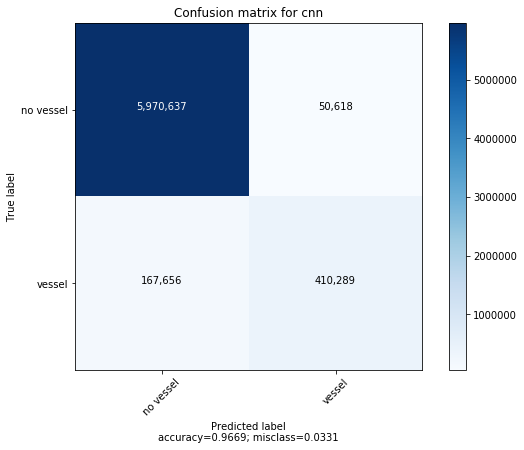

In [21]:
pred_arr = np.array(pred_list)
pred_arr[pred_arr >= 0.5] = 1
pred_arr[pred_arr <0.5] = 0
cm = confusion_matrix(np.array(gt_list),pred_arr)

plot_confusion_matrix(cm=cm, target_names=['no vessel', 'vessel'], normalize=False,
                      title='Confusion matrix for cnn')

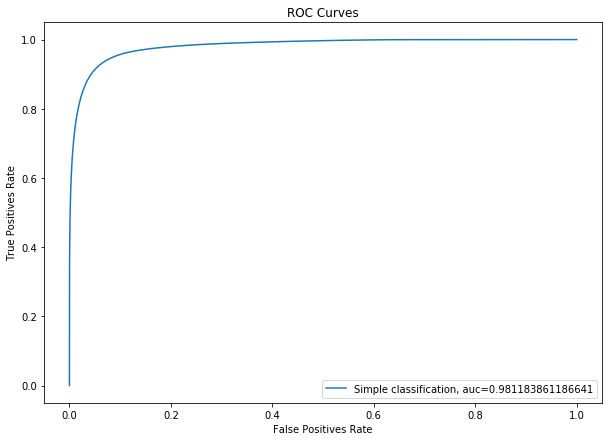

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, _ = roc_curve(gt_list,pred_list)
auc = roc_auc_score(gt_list,pred_list)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="Simple classification, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curves')
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.show()

In [24]:
[tn, fp], [fn, tp] = cm

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1score = 2*precision*sensitivity / (sensitivity + precision)

print("sensitivity: ", sensitivity)
print("specificity: ", specificity)
print("precision: ", precision)
print("f1score: ", f1score)

sensitivity:  0.7099101125539627
specificity:  0.9915934468810904
precision:  0.8901774110612336
f1score:  0.7898892238740456
